<a href="https://colab.research.google.com/github/helonayala/sysid/blob/main/IFAC2015_LTV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IFAC 2015 LTV system

Please see https://www.sciencedirect.com/science/article/pii/S2405896315029663


In [6]:
import requests
import zipfile
import os
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm # Import tqdm

# 1. Define the URL and file names
zip_url = "https://www.kth.se/social/files/558d84b7f276541077ddc833/data_LPV.zip"
zip_filename = "data_LPV.zip"
mat_filename = "MS_Ramp_N15640_RMS140_P2P700.mat"
extracted_dir = "data_LPV_extracted"

# 2. Download the zip file with a progress bar
print(f"Downloading {zip_filename}...")
try:
    response = requests.get(zip_url, stream=True) # Use stream=True to download content in chunks
    response.raise_for_status() # Raise an exception for bad status codes

    total_size = int(response.headers.get('content-length', 0))
    block_size = 1024 # 1 Kibibyte

    with open(zip_filename, "wb") as f:
        # Wrap the response content iteration with tqdm for a progress bar
        with tqdm(total=total_size, unit='iB', unit_scale=True, unit_divisor=1024, desc=zip_filename) as pbar:
            for chunk in response.iter_content(chunk_size=block_size):
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)
                    pbar.update(len(chunk))
    print("Download complete.")
except requests.exceptions.RequestException as e:
    print(f"Error downloading the file: {e}")
    exit()

# 3. Unzip the file
print(f"Unzipping {zip_filename}...")
try:
    with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
        zip_ref.extractall(extracted_dir)
    print("Unzipping complete.")
except zipfile.BadZipFile as e:
    print(f"Error unzipping the file: {e}")
    exit()


data_LPV.zip: 100%|██████████| 217M/217M [04:22<00:00, 865kiB/s]


Download complete.
Unzipping data_LPV.zip...
Unzipping complete.


In [7]:
# 4. Load the .mat file
mat_filepath = os.path.join(extracted_dir, mat_filename)
print(f"Loading {mat_filename}...")
try:
    mat_contents = scipy.io.loadmat(mat_filepath)
    print("MAT file loaded successfully.")
except FileNotFoundError:
    print(f"Error: {mat_filename} not found in {extracted_dir}")
    exit()
except Exception as e:
    print(f"Error loading MAT file: {e}")
    exit()

# 5. Extract variables and create time vector
# Assuming 'fs' (sampling frequency) is also in the .mat file or a known value.
# If 'fs' is not in the .mat file, you'll need to provide it.
# Let's assume 'fs' is a variable in the .mat file.
if 'fs' in mat_contents:
    fs = mat_contents['fs'].item() # .item() to get scalar from 0-d array
else:
    print("Warning: 'fs' (sampling frequency) not found in .mat file. Assuming 1000 Hz.")
    fs = 1000.0 # Default value if 'fs' is not found

try:
    p_ref = mat_contents['p_ref']
    u_ref = mat_contents['u_ref']
    y_m = mat_contents['y_m']

    print("Variables extracted.")
except KeyError as e:
    print(f"Error: One of the required variables (p_ref, u_ref, y_m) or 'fs' not found in the .mat file: {e}")
    exit()

print(f"No. of experiments: {u_ref.shape[1]}")

# 7. Clean up downloaded and extracted files (optional)
print("Cleaning up downloaded and extracted files...")
try:
    os.remove(zip_filename)
    import shutil
    shutil.rmtree(extracted_dir)
    print("Cleanup complete.")
except OSError as e:
    print(f"Error during cleanup: {e}")

Loading MS_Ramp_N15640_RMS140_P2P700.mat...
MAT file loaded successfully.
Variables extracted.
No. of experiments: 3
Cleaning up downloaded and extracted files...
Cleanup complete.


In [21]:
# 6. Plot the variables
N = mat_contents['p_ref'].shape[0]
SIGNAL = 1 # there are 3 experiments

p = p_ref[:, SIGNAL]
u = u_ref[:, SIGNAL]
y = y_m[:N, SIGNAL]


(15640,)

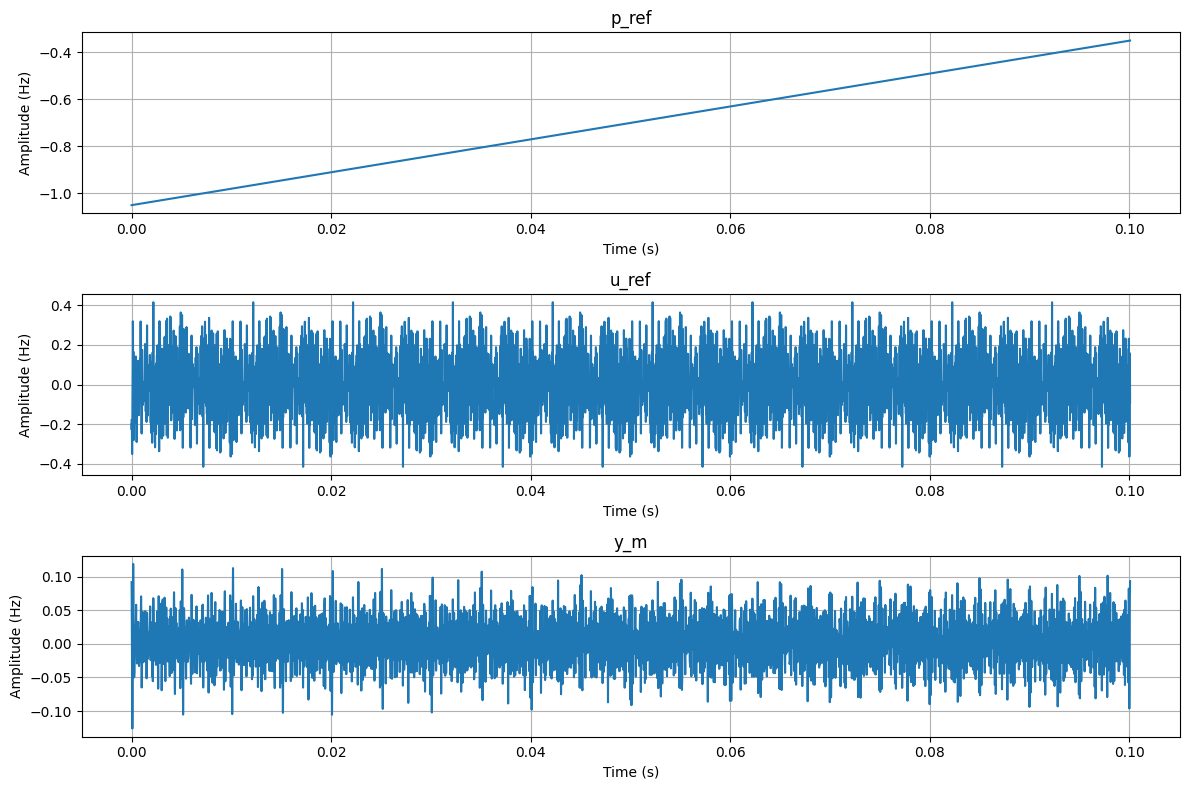

In [22]:

# Create time vector
time = np.arange(len(p)) / fs
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(time, p)
plt.title('p_ref')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (Hz)')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(time, u)
plt.title('u_ref')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (Hz)')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(time, y)
plt.title('y_m')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (Hz)')
plt.grid(True)

plt.tight_layout()
plt.show()


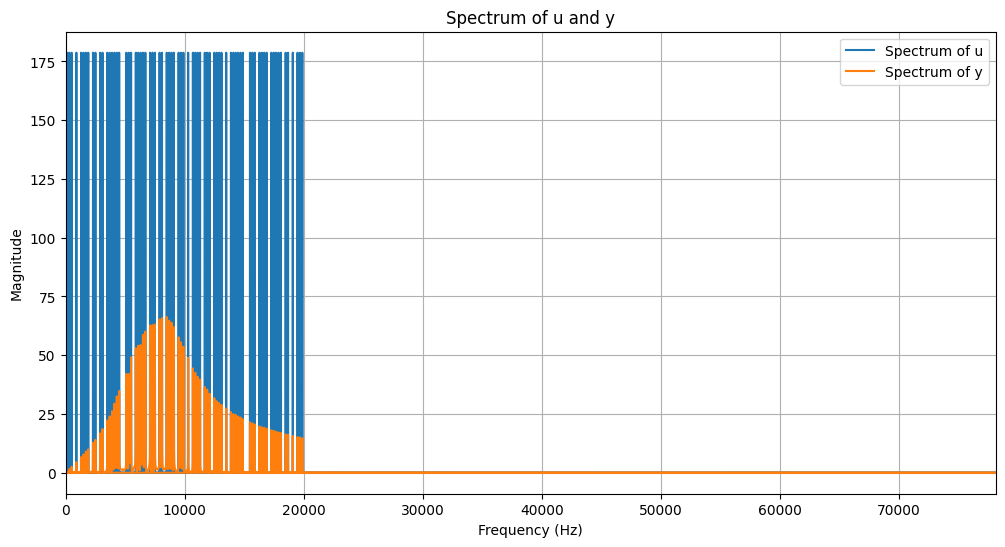

In [23]:
# prompt: plot the spectrum of u and y (in the same graph)

import matplotlib.pyplot as plt
import numpy as np
# Compute the spectrum using FFT
U_freq = np.fft.fft(u)
Y_freq = np.fft.fft(y)

# Create frequency vector
freqs = np.fft.fftfreq(len(u), 1/fs)

# Plot the magnitude spectrum
plt.figure(figsize=(12, 6))
plt.plot(freqs, np.abs(U_freq), label='Spectrum of u')
plt.plot(freqs, np.abs(Y_freq), label='Spectrum of y')
plt.title('Spectrum of u and y')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim(0, fs/2) # Plot only positive frequencies
plt.grid(True)
plt.legend()
plt.show()